In [1]:
import os
import gym
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from keras import backend as K
from keras import optimizers
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv
from _base import build_env, experiment_dir
from _top_level import top_level
top_level()

Using TensorFlow backend.


In [2]:
from src.agents import DeepQAgent
from src.base import AnnealingVariable
from src.wrappers import wrap
from src.models.losses import huber_loss
from src.callbacks import BaseCallback
from src.callbacks import JupyterCallback
from src.utils import seed

# Environment

In [3]:
# set the global random number seed
seed(1)

In [4]:
# create the output directory for this experiment's data
output_dir = experiment_dir('../results', 'SuperMarioBros-Meta', DeepQAgent.__name__)
output_dir

'../results/SuperMarioBros-Meta/DeepQAgent/2019-01-21_20-43'

In [5]:
def make_environment(monitor: bool=False, validation: bool=False, seed: int=1) -> gym.Env:
    """
    Make a gym environment for training, validation, or testing.

    Args:
        monitor: whether to apply a monitor to the environment
        seed: an optional random number seed for the environment

    Returns:
        a build gym environment with necessary wrappers applied

    """
    # make the environment
    if validation:
        env = gym.make('SuperMarioBros-v0')
    else:
        env = gym.make('SuperMarioBrosRandomStages-v0')
    # wrap the environment with an action space reducer
    env = BinarySpaceToDiscreteSpaceEnv(env, SIMPLE_MOVEMENT)
    # wrap the environment with transformers
    env = wrap(env,
        cache_rewards=True,
        noop_max=30,
        frame_skip=4,
        max_frame_skip=False,
        image_size=(84, 84),
        death_penalty=None,
        clip_rewards=False,
        agent_history_length=4
    )
    # monitor the video / data feed from the environment
    if monitor:
        monitor_dir = os.path.join(output_dir, 'monitor')
        env = gym.wrappers.Monitor(env, monitor_dir, force=True)
    # set the RNG seed for the environment
    if seed is not None:
        env.unwrapped.seed(seed)

    return env

In [6]:
env = make_environment()

# Training

In [7]:
# create a file to save the weights to
weights_file = os.path.join(output_dir, 'weights.h5')

In [8]:
# create an agent
agent = DeepQAgent(env,
    render_mode='human',
    replay_memory_size=650000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=optimizers.Adam(lr=2e-5),
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=1e6),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=False,
)
agent

DeepQAgent(
    env=<FrameStackEnv<DownsampleEnv<FrameSkipEnv<NoopResetEnv<RewardCacheEnv<BinarySpaceToDiscreteSpaceEnv<TimeLimit<SuperMarioBrosRandomStagesEnv<SuperMarioBrosRandomStages-v0>>>>>>>>>,
    render_mode='human'
    replay_memory_size=650000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=<keras.optimizers.Adam object at 0x7f995007aa90>,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=1000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=False
)

In [9]:
agent.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 84, 84, 4)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 32)   8224        lambda_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 20, 20, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
# observe random movement to pre-fill replay experience queue
agent.observe()

898frame [00:06, 131.93frame/s]                      


In [11]:
# create a callback for the training procedure to log weights and metrics
callback = BaseCallback(weights_file)
# create a callback for the training procedure to plot in Jupyter
# plotter = JupyterCallback()
# train the agent with given parameters and callbacks
agent.train(6e6, callback=callback)
# save the weights to disk after the training procedure
agent.model.save_weights(weights_file, overwrite=True)

754frame [00:08, 81.06frame/s, loss=29.2, score=317]                           


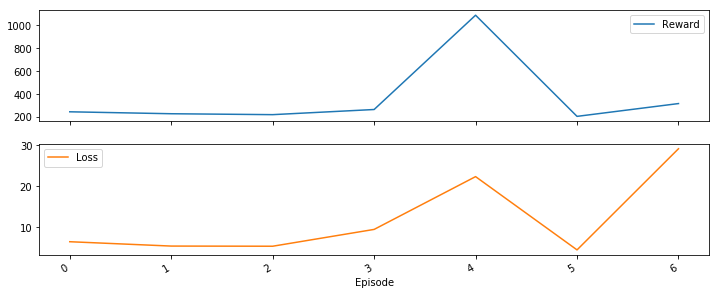

In [12]:
# export plot data from the base callback to disk
callback.export(os.path.join(output_dir, 'training'))

In [13]:
# close the training environment
env.close()
# clear the keras session to remove the training model from memory
K.clear_session()

# Validation

In [14]:
# create an environment for validation with a monitor attached
env = make_environment(validation=True)
# create a validation agent
agent = DeepQAgent(env, render_mode='human')
# load the trained weights into the validation agent
agent.model.load_weights(weights_file)

In [15]:
# run the agent through validation episodes
df = agent.play()

100%|██████████| 10/10 [00:13<00:00,  1.11s/game, score=731]    


In [16]:
df.head()

,Score
Episode,
0,734
1,731
2,728
3,1036
4,731


In [17]:
df.tail()

,Score
Episode,
5,1060
6,736
7,734
8,732
9,731


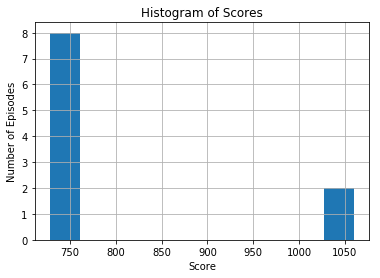

In [18]:
# plot the validation results and save the tables and figures to disk
agent.plot_episode_rewards(os.path.join(output_dir, 'play'))

In [19]:
env.close()